In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import ipdb

## Configurations

In [2]:
#TODO: There are many configuration parameters here. It is important to understand the effect of all.
d = 20

#This variance will determine the size of sensitivity parameter.
coeff_var = 1
Sigma_x = np.eye(d)
sigma_y = 10
stage_two_iter = 70
num_test = 10000

In [3]:
beta_p1 = np.random.normal(size = d)
beta_p2 = np.random.normal(size = d)


mu_p1 = np.random.normal(scale = coeff_var, size = d)
mu_p2 = np.random.normal(scale = coeff_var, size = d)
gamma_p1 = np.random.normal(scale = coeff_var, size = d)
gamma_p2 = np.random.normal(scale = coeff_var, size = d)

## Helper functions

In [4]:
"""
TODO:
Fill in these missing functions
Pass the arguments around correctly
Debug and make plot of performative risk
Try for d=2 and make a trajectory plot too
"""

def obtain_data(n, d, mu_p1, gamma_p1, mu_p2, gamma_p2, cov_x, sigma_y):
    theta_p1_lst = []
    z_p1_lst, z_p2_lst = [], []
    theta_p2_lst = []
    
    for i in np.arange(2*n):
        #Both players play random actions to gather information
        theta_p1_i, theta_p2_i = np.random.normal(size = d), np.random.normal(size = d)
        theta_p1_lst.append(theta_p1_i)
        theta_p2_lst.append(theta_p2_i)

        #Both players 
        z_p1_i = sample_from_distribution(cov_x, sigma_y, beta_p1, mu_p1, gamma_p1, theta_p1_i, theta_p2_i)
        z_p2_i = sample_from_distribution(cov_x, sigma_y, beta_p2, mu_p2, gamma_p2, theta_p1_i, theta_p2_i)
        z_p1_lst.append(z_p1_i)
        z_p2_lst.append(z_p2_i)
    
    return np.array(z_p1_lst), np.array(z_p2_lst), np.array(theta_p1_lst), np.array(theta_p2_lst)


def sample_from_distribution(cov_x, sigma_y, beta, mu, gamma, theta_p1, theta_p2):
    x = np.random.multivariate_normal(np.zeros(len(cov_x)), cov_x)
    U_y = np.random.normal(0, sigma_y)
    y = beta.T @ x + mu.T @ theta_p1 + gamma.T @ theta_p2 + U_y
    return (x, y)
    
def solve_distribution_params(z_lst, theta_p1_lst, theta_p2_lst):
    y = [e[1] for e in z_lst]
    A = np.hstack((theta_p1_lst, theta_p2_lst))
    mu_tilde = np.linalg.inv(A.T @ A) @ A.T @ y
    
    num_each = int(len(mu_tilde)/2)
    mu_hat = mu_tilde[:num_each]
    gamma_hat = mu_tilde[num_each:]
    return mu_hat, gamma_hat

def find_qs(mu_hat, gamma_hat, z_lst, theta_p1_lst, theta_p2_lst):
    y_lst = [e[1] for e in z_lst]
    q_lst = []
    for (idx, y) in enumerate(y_lst):
        theta_p1 = theta_p1_lst[idx]
        theta_p2 = theta_p2_lst[idx]
        q = y - np.dot(mu_hat, theta_p1) - np.dot(gamma_hat, theta_p2)
        q_lst.append(q)
    return np.array(q_lst)
        
    
def solve_theta(x_lst, q, mu_hat, gamma_hat, theta_other):
    y_mod = q + np.dot(gamma_hat, theta_other)*np.ones(len(q))
    x_arr = np.array(x_lst)
    #TODO: Ensure that this subtracts from each row like I expect
    A = x_arr - mu_hat
    theta = np.linalg.inv(A.T @ A) @ A.T @ y_mod
    #ipdb.set_trace()
    return theta


def run_first_stage(z_p1_lst, z_p2_lst, theta_p1_lst, theta_p2_lst):
    mu_hat_p1, gamma_hat_p1 = solve_distribution_params(z_p1_lst, theta_p1_lst, theta_p2_lst)
    mu_hat_p2, gamma_hat_p2 = solve_distribution_params(z_p2_lst, theta_p1_lst, theta_p2_lst)
    return mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2

def run_second_stage(x_p1_lst, q_p1, x_p2_lst, q_p2, mu_hat_p1, 
                        gamma_hat_p1, mu_hat_p2, gamma_hat_p2, num_iter):
    
    theta_p1_init, theta_p2_init = np.random.normal(size = d), np.random.normal(size = d)
    theta_p1_lst, theta_p2_lst = [theta_p1_init], [theta_p2_init]
    
    for k in range(num_iter):
        #Solve theta for player 1
        theta_p2_prev = theta_p2_lst[-1]
        theta_p1_k= solve_theta(x_p1_lst, q_p1, mu_hat_p1, gamma_hat_p1, theta_p2_prev)
        
        
        #Solve theta for player 2
        theta_p1_prev = theta_p1_lst[-1]
        theta_p2_k= solve_theta(x_p2_lst, q_p2, mu_hat_p2, gamma_hat_p2, theta_p1_prev)
        
        theta_p1_lst.append(theta_p1_k)
        theta_p2_lst.append(theta_p2_k)
    
    return theta_p1_lst, theta_p2_lst

def evaluate_test_performative_risk(beta, mu, gamma, theta_p1, theta_p2, cov_x, sigma_y, num_test):
    test_set = [sample_from_distribution(cov_x, sigma_y, beta, mu, gamma, theta_p1, theta_p2) for e in range(num_test)]
    x_test = np.array([e[0] for e in test_set])
    y_test = [e[1] for e in test_set]
    y_pred = x_test @ theta_p1
    mse = np.linalg.norm(y_test - y_pred)**2
    mse_avg = mse/len(y_test)
    return mse_avg

def solve_PO_given_theta():
    pass

#TODO: cov_x and sigma_y could also be different for the two players. Change this later.
def run_game(n, d, mu_p1, gamma_p1, mu_p2, gamma_p2, num_iter_stage_two, num_test, cov_x, sigma_y, beta_p1, beta_p2): 
    
    #Obtain and split up the data for both stages
    z_p1_lst, z_p2_lst, theta_p1_lst, theta_p2_lst = obtain_data(n, d, mu_p1, gamma_p1, 
                                                                 mu_p2, gamma_p2, cov_x, sigma_y)
    
    num_first_stage = n
    z_p1_lst_sliced = (z_p1_lst[:num_first_stage], z_p1_lst[num_first_stage:])
    z_p2_lst_sliced = (z_p2_lst[:num_first_stage], z_p2_lst[num_first_stage:])

    theta_p1_lst_sliced = (theta_p1_lst[:num_first_stage], theta_p1_lst[num_first_stage:])
    theta_p2_lst_sliced = (theta_p2_lst[:num_first_stage], theta_p2_lst[num_first_stage:])
    
    #Stage 1
    mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2 = run_first_stage(z_p1_lst_sliced[0], z_p2_lst_sliced[0], 
                                                                       theta_p1_lst_sliced[0], theta_p2_lst_sliced[0])
    
    print(mu_p1)
    print(mu_hat_p1)
    print(mu_p2)
    print(mu_hat_p2)
    
    #Obtain qs for stage 2
    q_p1_lst = find_qs(mu_hat_p1, gamma_hat_p1, z_p1_lst_sliced[1], theta_p1_lst_sliced[1], theta_p2_lst_sliced[1])
    q_p2_lst = find_qs(mu_hat_p2, gamma_hat_p2, z_p2_lst_sliced[1], theta_p1_lst_sliced[1], theta_p2_lst_sliced[1])
    
    #Stage 2
    x_lst_p1 = [e[0] for e in z_p1_lst_sliced[1]]
    x_lst_p2 = [e[0] for e in z_p2_lst_sliced[1]]
    
    theta_p1_final_lst, theta_p2_final_lst = run_second_stage(x_lst_p1, q_p1_lst, x_lst_p2, q_p2_lst, 
                                                  mu_hat_p1, gamma_hat_p1, mu_hat_p2, gamma_hat_p2, num_iter_stage_two)
    
    perf_risk_p1 = evaluate_test_performative_risk(beta_p1, mu_p1, gamma_p1, theta_p1_final_lst[-1], 
                                                   theta_p2_final_lst[-1], cov_x, sigma_y, num_test)
    
    
    perf_risk_p2 = evaluate_test_performative_risk(beta_p2, mu_p2, gamma_p2, theta_p1_final_lst[-1], 
                                                   theta_p2_final_lst[-1], cov_x, sigma_y, num_test)
    
    return perf_risk_p1, perf_risk_p2

In [5]:
n_lst = [10, 20, 30, 50, 100, 1000, 10000]
pr_p1_lst = []
pr_p2_lst = []

for n_r in n_lst:
    pr_p1, pr_p2 = run_game(n_r, d, mu_p1, gamma_p1, mu_p2, gamma_p2, stage_two_iter, num_test, 
                            Sigma_x, sigma_y, beta_p1, beta_p2)
    pr_p1_lst.append(pr_p1)
    pr_p2_lst.append(pr_p2)

<ipython-input-4-99a71acc0833>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(z_p1_lst), np.array(z_p2_lst), np.array(theta_p1_lst), np.array(theta_p2_lst)


[ 0.55732623  1.62517863 -0.64824146  0.52444119  1.1383284  -0.7155998
 -0.05848389 -1.03913391 -1.21470677  1.28727126  2.15781843 -0.72869586
  1.31536044 -1.69455773  0.45850842  0.65906707 -1.3295482  -0.59460927
 -1.65351169  2.10380513]
[  66.43134302   -0.62767824 -213.35635546  236.32629663 -153.11118777
 -183.42997993  137.69380848 -123.02488433  222.67740207   88.53454807
   20.32907811   12.69069873   95.61370212  117.80523191   -9.54018207
  -27.84513916  -26.90221969  -10.88815926  -23.98158819   33.58883015]
[ 0.31329672 -0.66046639 -0.42386325  0.0742309  -0.79167188 -0.72051871
 -1.05451535  0.64168864 -1.00397368 -1.27216688 -1.10710002 -0.83691747
  0.21292662  0.64991909 -0.74300578 -0.04818898  3.0763192  -0.9847996
 -2.26748767  0.66450643]
[-155.35839704 -137.83849907   82.32070659  176.71288171   75.37252092
  210.92168498 -125.49707223  -55.6484524  -132.66557226 -123.11047418
  -51.12528835  -43.43250239   16.56251642  171.12199311  111.35820287
   86.55376223

In [6]:
# get the Performative Optima
def solve_theta_PO(mu_1,mu_2,gamma_1,gamma_2, beta_1,beta_2,Sigma_x):
    mu_Sig_1 = np.outer(mu_1, mu_1) - Sigma_x
    mu_Sig_2 = np.outer(mu_2, mu_2) - Sigma_x
    mu_gamma_1 = np.outer(mu_1, gamma_1) 
    mu_gamma_2 = np.outer(mu_2, gamma_2) 
    A_1 = np.linalg.inv(mu_Sig_2 @ np.linalg.inv(mu_gamma_1) @ mu_Sig_1 - mu_gamma_2)
    A_2 = np.linalg.inv(mu_Sig_1 @ np.linalg.inv(mu_gamma_2) @ mu_Sig_2 - mu_gamma_1)
    
    B_1 = mu_Sig_2 @ np.linalg.inv(mu_gamma_1) @ Sigma_x @ beta_1 - Sigma_x @ beta_2
    B_2 = mu_Sig_1 @ np.linalg.inv(mu_gamma_2) @ Sigma_x @ beta_2 - Sigma_x @ beta_1
    
    
    theta_PO_1 = A_1 @ B_1
    theta_PO_2 = A_2 @ B_2
    return theta_PO_1, theta_PO_2


theta_PO_p1, theta_PO_p2 = solve_theta_PO(mu_p1,mu_p2,gamma_p1,gamma_p2, beta_p1, beta_p2, Sigma_x)

pr_PO_p1 = evaluate_test_performative_risk(beta_p1, mu_p1, gamma_p1, theta_PO_p1, 
                                                   theta_PO_p2, Sigma_x, sigma_y, num_test)
pr_PO_p2 = evaluate_test_performative_risk(beta_p2, mu_p2, gamma_p2, theta_PO_p1, 
                                                   theta_PO_p2, Sigma_x, sigma_y, num_test)
    

In [7]:
print(pr_PO_p1, pr_PO_p2)


186.29353972822585 185.37640266241274


## Create plot

In [8]:
import seaborn as sns
sns.set_style('darkgrid')

Text(0, 0.5, '$PR(\\theta)$')

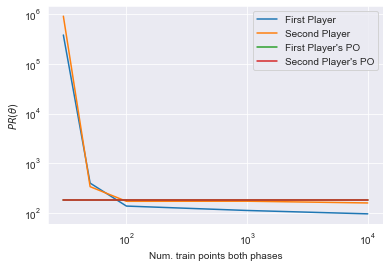

In [9]:
plt.plot(n_lst[2:], pr_p1_lst[2:], label = 'First Player')
plt.plot(n_lst[2:], pr_p2_lst[2:], label = 'Second Player')
plt.plot(n_lst[2:], pr_PO_p1* np.ones( (len(n_lst[2:]), 1)) , label = 'First Player\'s PO')
plt.plot(n_lst[2:], pr_PO_p2* np.ones( (len(n_lst[2:]), 1)) , label = 'Second Player\'s PO')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.xlabel("Num. train points both phases")
plt.ylabel(r"$PR(\theta)$")
#plt.savefig("/Users/adhyyan/Desktop/multiplayer_pp_simulation.pdf", format = 'pdf')